In [2]:
!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 2>/dev/null
!pip install -U evaluate transformers datasets>=2.14.5 accelerate>=0.27 mlflow

In [3]:
import warnings
warnings.filterwarnings("ignore") 
import gc
import numpy as np 
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt  
from sklearn.metrics import (
    accuracy_score,  
    roc_auc_score, 
    confusion_matrix, 
    classification_report,  
    f1_score  
)
from imblearn.over_sampling import RandomOverSampler
import accelerate
import evaluate
from datasets import Dataset, Image, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
    DefaultDataCollator
)
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomRotation,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    Resize,
    ToTensor
)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

2024-12-12 07:44:49.759217: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 07:44:49.759339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 07:44:49.904572: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
image_dict = {}

from pathlib import Path
from tqdm import tqdm
import os

file_names = []
labels = []

for file in sorted((Path('/kaggle/input/deepfake-and-real-images/Dataset/').glob('*/*/*.*'))):
    label = str(file).split('/')[-2]  
    labels.append(label)  
    file_names.append(str(file)) 
    
print(len(file_names), len(labels))
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)

190335 190335
(190335, 2)


In [5]:
df.head()

,image,label
0,/kaggle/input/deepfake-and-real-images/Dataset...,Fake
1,/kaggle/input/deepfake-and-real-images/Dataset...,Fake
2,/kaggle/input/deepfake-and-real-images/Dataset...,Fake
3,/kaggle/input/deepfake-and-real-images/Dataset...,Fake
4,/kaggle/input/deepfake-and-real-images/Dataset...,Fake


In [6]:
df['label'].unique()

array(['Fake', 'Real'], dtype=object)

In [7]:
y = df[['label']]
df = df.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)

df, y_resampled = ros.fit_resample(df, y)
del y
df['label'] = y_resampled
del y_resampled
gc.collect()

print(df.shape)

(190402, 2)


In [8]:
dataset = Dataset.from_pandas(df).cast_column("image", Image())

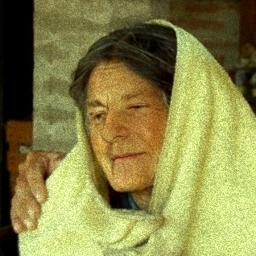

In [9]:
dataset[0]["image"]

In [10]:
labels_subset = labels[:5]
print(labels_subset)

['Fake', 'Fake', 'Fake', 'Fake', 'Fake']


In [11]:
labels_list = ['Real', 'Fake']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels_list):
    label2id[label] = i  
    id2label[i] = label
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Real', 1: 'Fake'} 

Mapping of Labels to IDs: {'Real': 0, 'Fake': 1}


In [12]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example
dataset = dataset.map(map_label2id, batched=True)
dataset = dataset.cast_column('label', ClassLabels)
dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")
train_data = dataset['train']
test_data = dataset['test']

Map:   0%|          | 0/190402 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/190402 [00:00<?, ? examples/s]

In [15]:
model_str = "dima806/deepfake_vs_real_image_detection" 
processor = ViTImageProcessor.from_pretrained(model_str)
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)
normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
    [
        Resize((size, size)),             
        RandomRotation(90),              
        RandomAdjustSharpness(2),      
        ToTensor(),             
        normalize                        
    ]
)
_val_transforms = Compose(
    [
        Resize((size, size)),            
        ToTensor(),                       
        normalize                    
    ]
)
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [16]:
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [17]:
def collate_fn(examples):   
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [19]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.config.id2label = id2label
model.config.label2id = label2id
print(model.num_parameters(only_trainable=True) / 1e6)

85.800194


In [20]:
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids
    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    return {
        "accuracy": acc_score
    }
   

In [21]:
metric_name = "accuracy"
model_name = "deepfake_vs_real_image_detection"

num_train_epochs = 1

args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=30,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)

In [22]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [23]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.053400,0.046628,0.983653


TrainOutput(global_step=3571, training_loss=0.09160314070948096, metrics={'train_runtime': 4309.157, 'train_samples_per_second': 26.511, 'train_steps_per_second': 0.829, 'total_flos': 8.852762385560605e+18, 'train_loss': 0.09160314070948096, 'epoch': 1.0})

In [24]:
trainer.evaluate()

{'eval_loss': 0.046627722680568695,
 'eval_accuracy': 0.9836530507740182,
 'eval_runtime': 667.8996,
 'eval_samples_per_second': 114.031,
 'eval_steps_per_second': 14.255,
 'epoch': 1.0}

In [25]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

{'test_loss': 0.046627722680568695, 'test_accuracy': 0.9836530507740182, 'test_runtime': 679.0137, 'test_samples_per_second': 112.164, 'test_steps_per_second': 14.022}


Accuracy: 0.9837
F1 Score: 0.9837


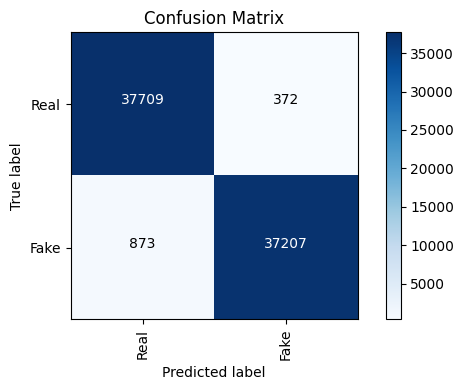


Classification report:

              precision    recall  f1-score   support

        Real     0.9774    0.9902    0.9838     38081
        Fake     0.9901    0.9771    0.9835     38080

    accuracy                         0.9837     76161
   macro avg     0.9837    0.9837    0.9837     76161
weighted avg     0.9837    0.9837    0.9837     76161



In [26]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):

   
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    plt.show()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(labels_list) <= 150:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(6, 4))
    
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [27]:
# Save the model and tokenizer
trainer.save_model("./saved_model")
processor.save_pretrained("./saved_model")


['./saved_model/preprocessor_config.json']

In [29]:
!zip -r file2.zip /kaggle/working/deepfake_vs_real_image_detection

  adding: kaggle/working/deepfake_vs_real_image_detection/ (stored 0%)
  adding: kaggle/working/deepfake_vs_real_image_detection/checkpoint-3571/ (stored 0%)
  adding: kaggle/working/deepfake_vs_real_image_detection/checkpoint-3571/config.json (deflated 48%)
  adding: kaggle/working/deepfake_vs_real_image_detection/checkpoint-3571/training_args.bin (deflated 52%)
  adding: kaggle/working/deepfake_vs_real_image_detection/checkpoint-3571/scheduler.pt (deflated 56%)
  adding: kaggle/working/deepfake_vs_real_image_detection/checkpoint-3571/rng_state.pth (deflated 25%)
  adding: kaggle/working/deepfake_vs_real_image_detection/checkpoint-3571/optimizer.pt (deflated 8%)
  adding: kaggle/working/deepfake_vs_real_image_detection/checkpoint-3571/trainer_state.json (deflated 64%)
  adding: kaggle/working/deepfake_vs_real_image_detection/checkpoint-3571/preprocessor_config.json (deflated 47%)
  adding: kaggle/working/deepfake_vs_real_image_detection/checkpoint-3571/model.safetensors (deflated 7%)
